# Notebook for removal batch effects using `BBKNNN`

**Created by :** Srivalli Kolla

**Created on :** 06 May, 2025

**Modified on :** 07 May, 2025

**University of Würzburg**

Env : scanpy (Python 3.12.2)

# Importing Packages

In [57]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import bbknn
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [58]:
sc.settings.verbosity = 3
sc.logging.print_versions()

plt.rcParams['figure.dpi'] = 300  
plt.rcParams['savefig.dpi'] = 300

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.11.3
scanpy      1.10.4
-----
Cython                      3.0.12
PIL                         11.1.0
annoy                       NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
bbknn                       1.6.0
certifi                     2025.01.31
cffi                        1.17.1
charset_normalizer          3.4.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython                      3.0.12
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
executing                   2.1.0
fastjsonschema              NA
fqdn                        NA
h5py                        3.13.0
idna                        3.10
igraph                      0.

/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


# Data import

In [59]:
adata = sc.read_h5ad('./Github/Nuclear_hashing_2025/data/demultiplexed_htodemux_scrublet_doublet_removal_magnetic_beads_07_05_25.h5ad')
adata

AnnData object with n_obs × n_vars = 7927 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'ident', 'Sample_given', 'Sample-ID', 'Mouse-ID', 'Sex', 'Group', 'Nuclei Purification Method after Hashing', 'assigned_hashtag', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'assigned_hashtag_colors', 'log1p'
    layers: 'cpm_normalization', 'logcounts', 'raw_counts'

In [60]:
adata.obs['Group'].value_counts()

Group
MCMV      4585
noninf    3342
Name: count, dtype: int64

#### Check if data is raw or Normalized

In [61]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [62]:
print(X_is_raw(adata))

False


In [63]:
adata.X= adata.layers['raw_counts']
print(X_is_raw(adata))

True


In [64]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    layer = "raw_counts",
    batch_key = 'assigned_hashtag',
    subset = False
)
adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 7927 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'ident', 'Sample_given', 'Sample-ID', 'Mouse-ID', 'Sex', 'Group', 'Nuclei Purification Method after Hashing', 'assigned_hashtag', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'assigned_hashtag_colors', 'log1p', 'hvg'
    layers: 'cpm_normalization', 'logcounts', 'raw_counts'

In [65]:
adata.var['highly_variable'].value_counts()

highly_variable
False    30285
True      2000
Name: count, dtype: int64

In [66]:
adata.X= adata.layers['cpm_normalization']
print(X_is_raw(adata))

False


# Data Overview 

# Before Batch Correction

## Clustering

In [67]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(adata, use_rep = "X_pca", n_neighbors = 50, metric = 'minkowski', random_state = 1786)

computing PCA
    with n_comps=50


/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [68]:
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1789)

computing UMAP


/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


## Data Visualization

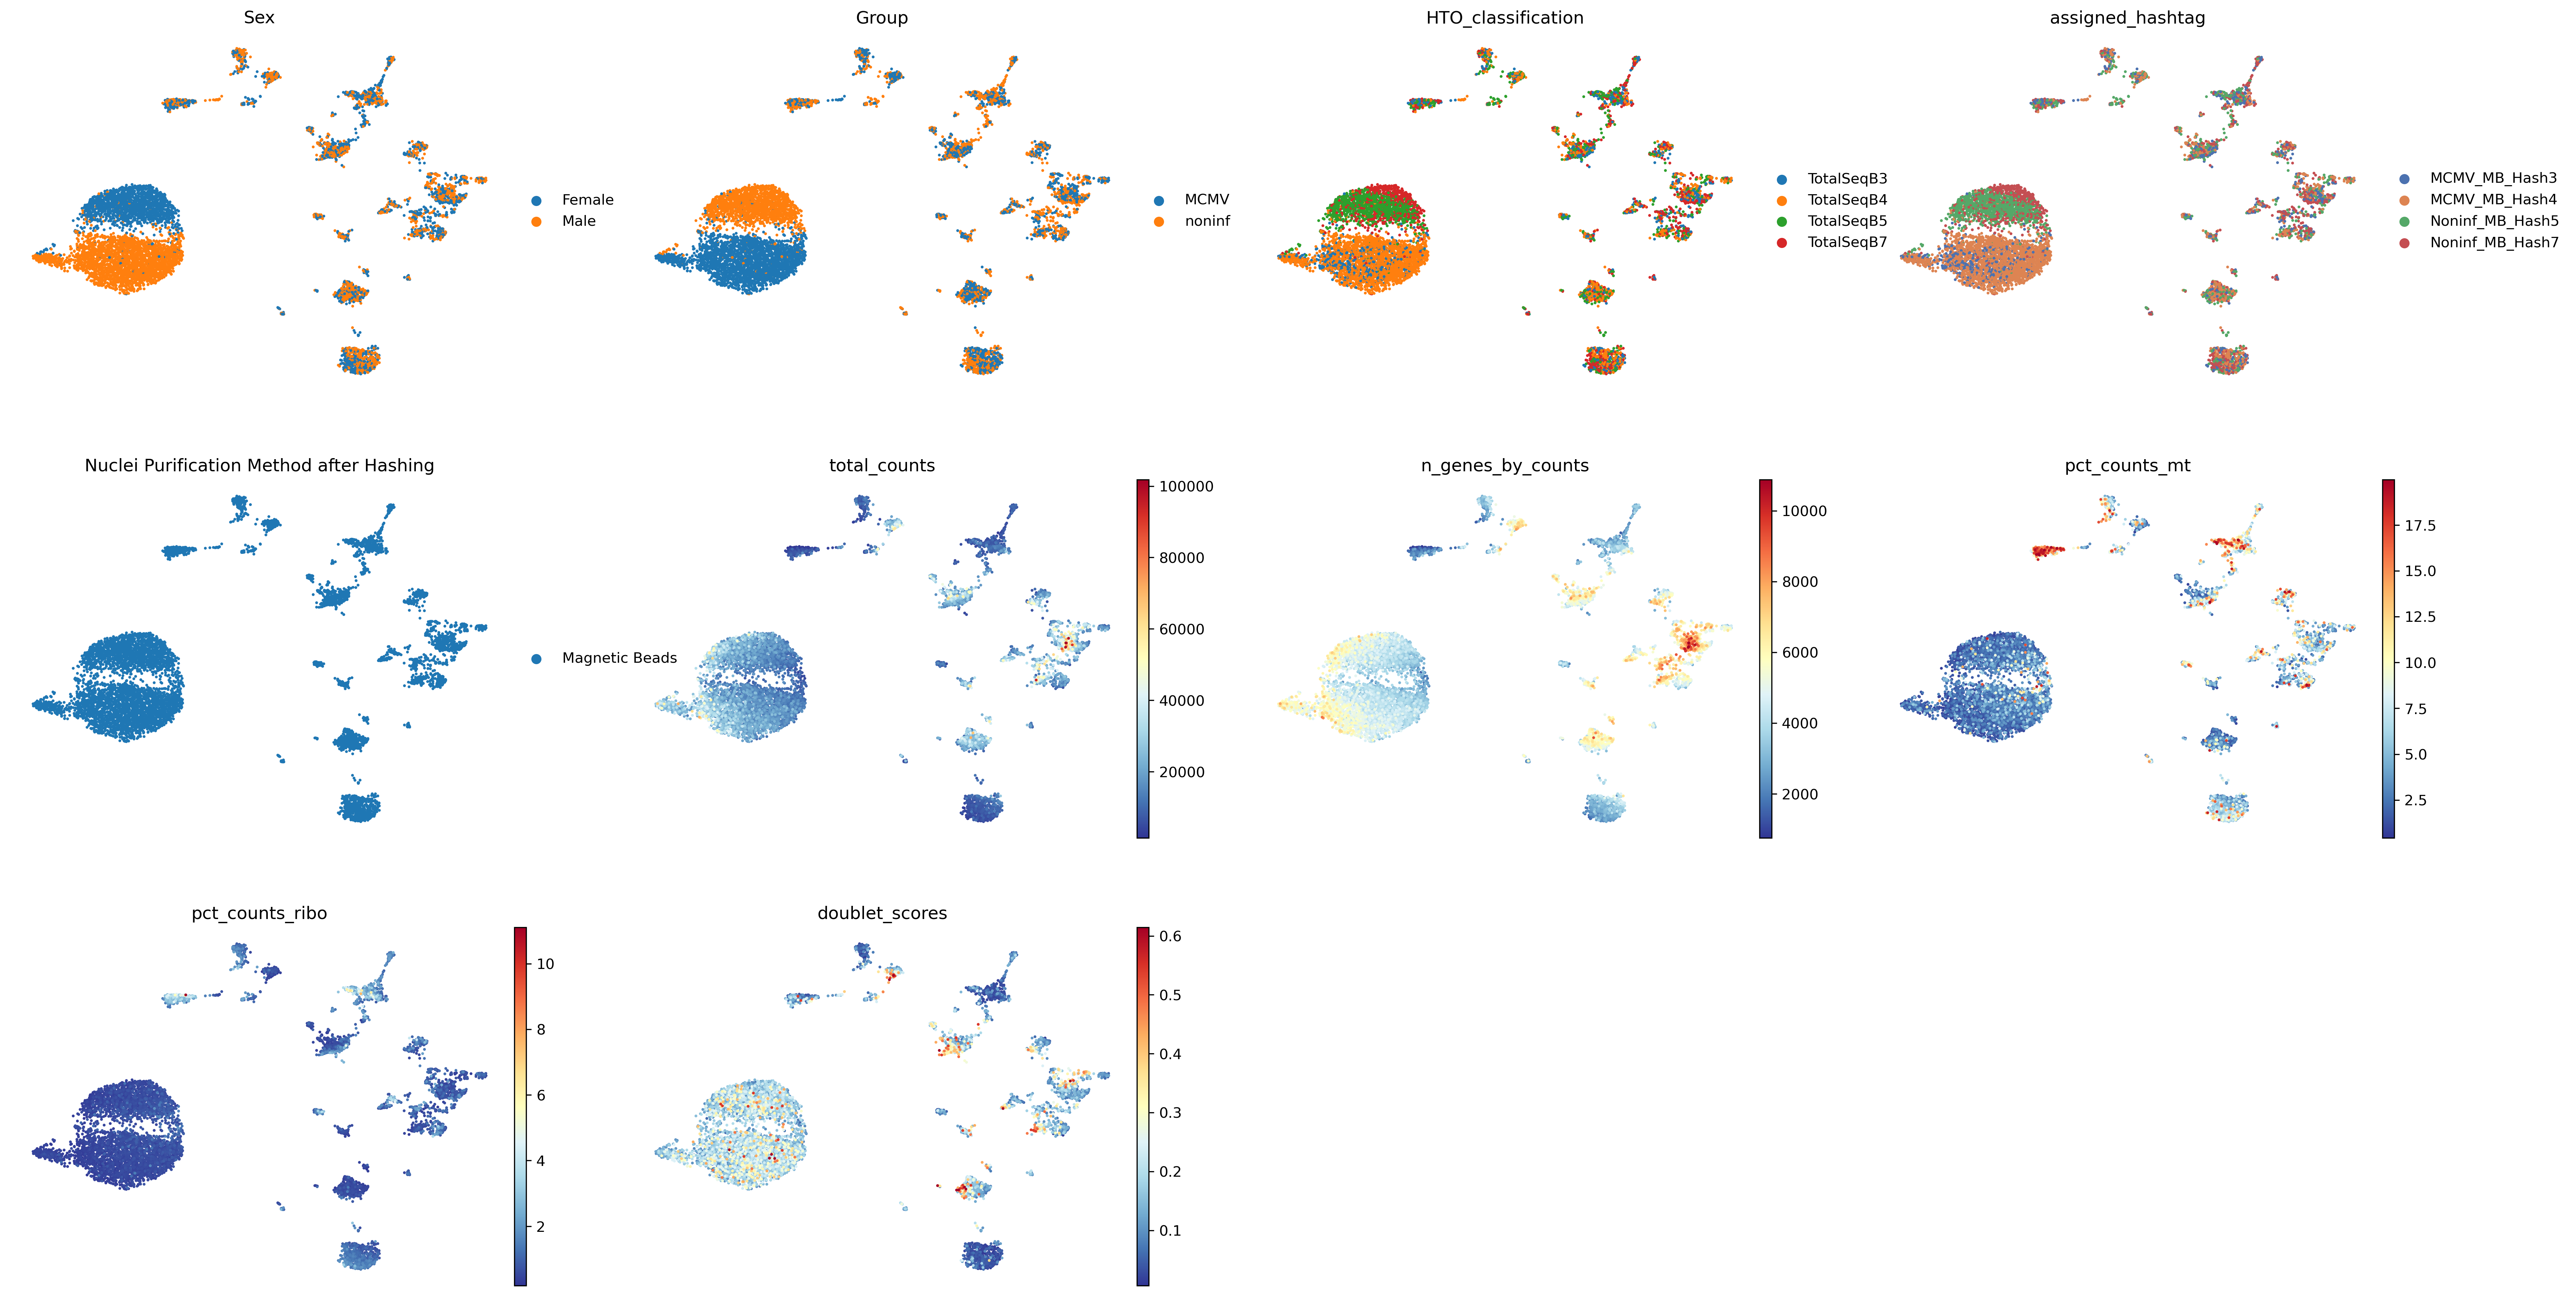

In [69]:
sc.pl.umap(adata,color= ['Sex', 'Group', 'HTO_classification', 'assigned_hashtag','Nuclei Purification Method after Hashing', 'total_counts','n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'doublet_scores'], frameon = False,layer = 'cpm_normalization', cmap = 'RdYlBu_r' )

# Batch effects removal

In [70]:
bbknn = bbknn.bbknn(adata, batch_key='assigned_hashtag', neighbors_within_batch = 4, approx = True, copy = True)
bbknn

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


AnnData object with n_obs × n_vars = 7927 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'ident', 'Sample_given', 'Sample-ID', 'Mouse-ID', 'Sex', 'Group', 'Nuclei Purification Method after Hashing', 'assigned_hashtag', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'assigned_hashtag_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Sex_colors', 'Group_colors', 'HTO_classification_colors', 'Nuclei Purification Method after Hashing_colors'
 

In [71]:
bbknn.write_h5ad(f'./Github/Nuclear_hashing_2025/data/demultiplexed_htodemux_bbknn_doublet_filtered_magnetic_beads_{timestamp}.h5ad')